# Amortized Bayesian Optimal Experimental Design (ABOED)

In [1]:
import hypothesis as h
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
h.plot.activate()

# Clear old files, if desired.
!rm -r data out

## The Weinberg demo revisited

The same setup as in https://github.com/cranmer/active_sciencing/blob/master/demo_weinberg.ipynb

However, within an active sciencing step, we will now estimate the EIG for all experiments at once. The idea is outlined here: https://joerihermans.com/talks/talk-umq/#12 and https://joerihermans.com/talks/talk-umq/#13

Note that we are kinda doing a greedy approach here (maximizing EIG at every step within the active sciencing procedure). One could apply an RL methodology to optimize a policy for picking the experimental configuration over a horizon of experiments. However, I would personally pick the posterior entropy as a utility. But that might be costly to evaluate, unless you assume pick some heuristic on the (estimated) posterior entropy.

### Intro

#### Prior over the Fermi constant

In [3]:
prior = h.benchmark.weinberg.Prior()

prior # Prior over the Fermi constant.

Uniform(low: 0.25, high: 2.0)

#### The prior over the experimental configurations

In [4]:
prior_experiment = h.benchmark.weinberg.PriorExperiment()

prior_experiment # Beam energy beteen 40 GeV and 50 GeV. Experiment is least informative around 45 GeV.

Uniform(low: 40.0, high: 50.0)

We make the reasonable assumption that the $p(\vartheta)$ and $p(\psi)$ are independent.

#### Simulator

In [5]:
simulator = h.benchmark.weinberg.Simulator()

### Presimulating the datasets

These can be re-used. No new simulations are required.

We only require samples from the joint $p(\vartheta,x,\psi)$ for this to work efficiently, where $\vartheta$ are the model parameters of interest (the Fermi constant), $x$ the observables (outputs of the simulation), and $\psi$ the experimental configuration. This could be done in parallel on some HPC cluster.

#### Training

In [6]:
n = 5 * 10 ** 5

if not os.path.exists("data/train/inputs.npy"):
    inputs = prior.sample((n, 1))  # Model parameters
    configs = prior_experiment.sample((n, 1))  # Experimental configurations
    outputs = simulator(inputs, configs)  # Observables

In [7]:
!mkdir -p data/train

In [8]:
if not os.path.exists("data/train/inputs.npy"):
    np.save("data/train/inputs.npy", inputs.numpy())
    np.save("data/train/configs.npy", configs.numpy())
    np.save("data/train/outputs.npy", outputs.numpy())

#### Testing

In [9]:
n = 5 * 10 ** 4

if not os.path.exists("data/test/inputs.npy"):
    inputs = prior.sample((n, 1))  # Model parameters
    configs = prior_experiment.sample((n, 1))  # Experimental configurations
    outputs = simulator(inputs, configs)  # Observables

In [10]:
!mkdir -p data/test

In [11]:
if not os.path.exists("data/test/inputs.npy"):
    np.save("data/test/inputs.npy", inputs.numpy())
    np.save("data/test/configs.npy", configs.numpy())
    np.save("data/test/outputs.npy", outputs.numpy())

### Overview of the procedure

To enable Amortized Bayesian Optimal Experimental Design, we require 2 ratio estimators. The first one *(Type-I)* needs to approximate (under the assumption that the random variables $\vartheta$ and $\psi$ are independent)

$$
\hat{r}(x\vert\vartheta,\psi)\approx\frac{p(\vartheta,x,\psi)}{p(\vartheta)p(x,\psi)} = \frac{p(x\vert\vartheta,\psi)}{p(x\vert\psi)} = \frac{p(\vartheta\vert x,\psi)}{p(\vartheta)},
$$
while the second ratio estimator *(Type-II)* approximates
$$
\hat{r}(x,\vartheta\vert\psi)\approx\frac{p(\vartheta,x,\psi)}{p(\vartheta,x)p(\psi)} = \frac{p(\vartheta,x\vert\psi)}{p(\vartheta,x)}.
$$

Jointly, the ratio estimators can be combined to compute (**when optimal**)

$$
\mathbb{E}_{p(\vartheta,x)}\left[r(\vartheta,x\vert\psi)\log r(x\vert\vartheta,\psi)\right],
$$

for a given experimental configuration $\psi$. This is equivalent to computing the **expected information gain** of an experimental configuration $\psi$, i.e., EIG$(\psi)$, because

$$
\mathbb{E}_{p(\vartheta,x)}\left[r(\vartheta,x\vert\psi)\log r(x\vert\vartheta,\psi)\right] = \int_\vartheta\int_x d\vartheta dx ~{p(\vartheta,x)} \frac{p(\vartheta,x\vert\psi)}{{p(\vartheta,x)}}\log\frac{p(x\vert\vartheta,\psi)}{p(x\vert\psi)}.
$$

Note that $p(\vartheta,x)$ cancels out. We therefore obtain

$$
\int_\vartheta\int_x d\vartheta dx ~{p(\vartheta,x\vert\psi)}\log\frac{p(x\vert\vartheta,\psi)}{p(x\vert\psi)} = \mathbb{E}_{p(\vartheta,x\vert\psi)}\left[\log\frac{p(x\vert\vartheta,\psi)}{p(x\vert\psi)}\right] = \mathbb{E}_{p(\vartheta,x\vert\psi)}\left[\log\frac{p(\vartheta\vert x,\psi)}{p(\vartheta)}\right] = \text{EIG}(\psi).
$$

The above implies that we do not need evaluate point estimates of the expectation for a given $\psi$, which requires **new** simulations at a specific experimental configuration $\psi$. Rather, we can use previously simulated points, and reweigh them to
compute the same expectation for all experimental configurations under $p(\psi)$!

#### Training the Type-I (lack of a better name) ratio estimator

**Note**: Training is done on CPU!

In addition, note that `hypothesis.nn.ratio_estimation.BalancedCriterion` is the experimental 'conservative' regularizer. I talked about before during the call we had: this criterion basically ensures that the empirical coverage probability >= the nominal one for some confidence level.

The idea is that we're essentially regularizing the ratio estimators, such that the estimated joint entropy (through the ratio estimator) is larger or equal to the true one. We have some math to show that seems to be the case, bu we are missing some component in the proof :( But experimentally it seems to hold agains to other techniques we were able to come up with.

In [12]:
%%time

if not os.path.exists("out/type-i/weights.th"): # Set to true to force retraining
    !python -m hypothesis.bin.ratio_estimation.train \
    --batch-size 1024 \
    --data-validate "ratio_estimation.DatasetTest" \
    --data-train "ratio_estimation.DatasetTrain" \
    --epochs 25 \
    --estimator "ratio_estimation.RatioEstimatorTypeI" \
    --out "out/type-i" \
    --lr 0.0001

CPU times: user 10.3 s, sys: 1.33 s, total: 11.6 s
Wall time: 5min 22s


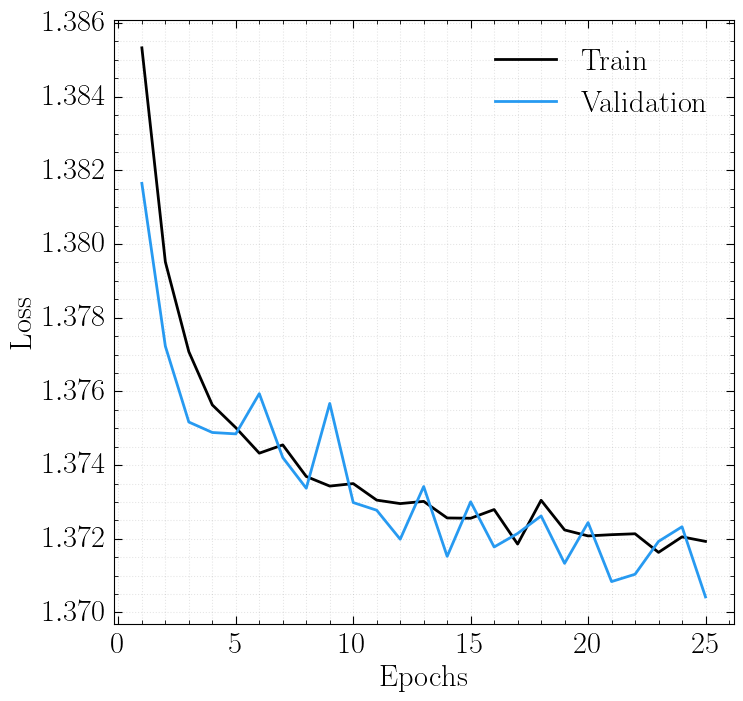

In [13]:
train_losses = np.load("out/type-i/losses-train.npy")
validation_losses = np.load("out/type-i/losses-validation.npy")

plt.xlabel("Epochs")
plt.ylabel("Loss")
epochs = np.arange(len(train_losses)) + 1
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, validation_losses, label="Validation")
plt.legend()
plt.show()

#### Training the Type-II ratio estimator

**Note**: Training is done on CPU!

In [ ]:
%%time 

if not os.path.exists("out/type-ii/weights.th"): # Set to true to force retraining
    !python -m hypothesis.bin.ratio_estimation.train \
    --batch-size 1024 \
    --data-validate "ratio_estimation.DatasetTest" \
    --data-train "ratio_estimation.DatasetTrain" \
    --epochs 25 \
    --estimator "ratio_estimation.RatioEstimatorTypeII" \
    --out "out/type-ii" \
    --lr 0.0001

In [ ]:
train_losses = np.load("out/type-ii/losses-train.npy")
validation_losses = np.load("out/type-ii/losses-validation.npy")

plt.xlabel("Epochs")
plt.ylabel("Loss")
epochs = np.arange(len(train_losses)) + 1
plt.plot(epochs, train_losses, label="Train")
plt.plot(epochs, validation_losses, label="Validation")
plt.legend()
plt.show()

#### Plotting the EIG through Monte Carlo approximation of the expectation

In [ ]:
from ratio_estimation import RatioEstimatorTypeI
from ratio_estimation import RatioEstimatorTypeII

r1 = RatioEstimatorTypeI()
r1.load_state_dict(torch.load("out/type-i/weights.th"))  # Pick ratio estimator which minimized the validation loss
r1.eval()

r2 = RatioEstimatorTypeII()
r2.load_state_dict(torch.load("out/type-ii/weights.th"))  # Pick ratio estimator which minimized the validation loss
r2.eval()

print("Loaded all ratio estimators!")


# Draw some new samples from the joint, or use some previously simulated samples.
n = 1024 # Tune if desired

inputs = prior.sample((n, 1)) 
configs = prior_experiment.sample((n, 1))  
outputs = simulator(inputs, configs)

In [ ]:
%%time

# Plot the EIG by scanning
configs = torch.linspace(prior_experiment.low, prior_experiment.high, 100)
eigs = []
for config in configs:
    c = config.repeat((n, 1))
    with torch.no_grad():
        eig = (r2.log_ratio(inputs=inputs, outputs=outputs, configs=c).exp() * r1.log_ratio(inputs=inputs, outputs=outputs, configs=c)).mean()
        eigs.append(eig.item())

plt.title("Amortized EIG estimation")
plt.plot(configs.numpy(), eigs)
plt.ylabel("EIG")
plt.xlabel(r"$\psi$ GeV")
plt.show()

As per https://github.com/cranmer/active_sciencing/blob/master/demo_weinberg.ipynb, experiment is most insenstive close to 45 GeV!

##### Picking the best experiment by maximizing the EIG

While in low-dimensional settings you could rely on a scanning-based approach. That's not that necessarily will work in higher, e.g., 3 dimensions or so. In that case you will have two options. But they all rely on *gradients* with respect to the experimental configuration. Essentially, we want to compute

$$
\nabla_\psi \text{EIG}(\psi),
$$

and simply apply gradient ascent through the neural networks as a way of maximizing the EIG.

In [ ]:
from tqdm import tqdm

n = 10000
inputs = prior.sample((n, 1)) 
configs = prior_experiment.sample((n, 1))  
outputs = simulator(inputs, configs)

def estimate_eig(psi):
    c = psi.repeat(len(inputs), 1)
    eig = (r2.log_ratio(inputs=inputs, outputs=outputs, configs=c).exp() * r1.log_ratio(inputs=inputs, outputs=outputs, configs=c)).mean()

    return eig
    
def argmax_eig(psi, steps=100, eta=0.75):
    psi = torch.tensor(psi).float()
    for _ in range(steps):
        psi.requires_grad = True
        if psi.grad is not None:
            psi.grad.zero_()
        eig = estimate_eig(psi)
        eig.backward()
        with torch.no_grad():
            psi = psi + eta * psi.grad  # Of course, you could use momentum e.d.
            
    return psi.detach()


optimal_psi = argmax_eig(45.0)

optimal_psi

In [ ]:
%%time

optimal_psi = argmax_eig(prior_experiment.sample())  # Other maximum?

optimal_psi